## Previsão de votação de Deputados

Nesta atividade construiremos modelos preditivos de regressão em scikit learn para a predição dos votos de deputados federais considerando as eleições de 2014

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
pd.set_option('display.max_columns', 500)
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import skew
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
df = pd.read_csv('eleicoes_2006_a_2010.csv')
df.head()

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,votos
0,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,6,6,16600.00,2766.666667,NaN,9000.0,6300.00,1300.0,14,14,16583.60,1184.542857,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,8579
1,2006,10002,LOIVA DE OLIVEIRA,RO,PT,13,13,22826.00,1755.846154,6625.0,15000.0,1000.00,201.0,24,23,20325.99,883.738696,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,2757
2,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,17,16,148120.80,9257.550000,2250.0,34150.0,62220.80,59500.0,123,108,146011.70,1351.960185,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,17428
3,2006,10002,ROMALDO MILANI,MS,PRONA,6,6,3001.12,500.186667,NaN,1150.0,1101.12,750.0,8,8,3001.12,375.140000,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,1193
4,2006,10003,ANSELMO DE JESUS ABREU,RO,PT,48,48,NaN,NaN,NaN,50878.0,NaN,68942.0,133,120,116416.64,970.138667,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,29401


In [3]:
df.dtypes

ano                                        int64
sequencial_candidato                       int64
nome                                      object
uf                                        object
partido                                   object
quantidade_doacoes                         int64
quantidade_doadores                        int64
total_receita                            float64
media_receita                            float64
recursos_de_outros_candidatos/comites    float64
recursos_de_pessoas_fisicas              float64
recursos_de_pessoas_juridicas            float64
recursos_proprios                        float64
quantidade_despesas                        int64
quantidade_fornecedores                    int64
total_despesa                            float64
media_despesa                            float64
cargo                                     object
sexo                                      object
grau                                      object
estado_civil        

### Observando dados faltosos

In [4]:
df.isna().sum()

ano                                         0
sequencial_candidato                        0
nome                                        0
uf                                          0
partido                                     0
quantidade_doacoes                          0
quantidade_doadores                         0
total_receita                             161
media_receita                             161
recursos_de_outros_candidatos/comites    2390
recursos_de_pessoas_fisicas              2683
recursos_de_pessoas_juridicas            3976
recursos_proprios                        2388
quantidade_despesas                         0
quantidade_fornecedores                     0
total_despesa                               0
media_despesa                               0
cargo                                       0
sexo                                        0
grau                                        0
estado_civil                                0
ocupacao                          

### Preenchendo dados faltosos

In [5]:
df = df.fillna(df.mean())
df.isna().sum()

ano                                      0
sequencial_candidato                     0
nome                                     0
uf                                       0
partido                                  0
quantidade_doacoes                       0
quantidade_doadores                      0
total_receita                            0
media_receita                            0
recursos_de_outros_candidatos/comites    0
recursos_de_pessoas_fisicas              0
recursos_de_pessoas_juridicas            0
recursos_proprios                        0
quantidade_despesas                      0
quantidade_fornecedores                  0
total_despesa                            0
media_despesa                            0
cargo                                    0
sexo                                     0
grau                                     0
estado_civil                             0
ocupacao                                 0
votos                                    0
dtype: int6

### Verificando a distribuição e correlação dos dados

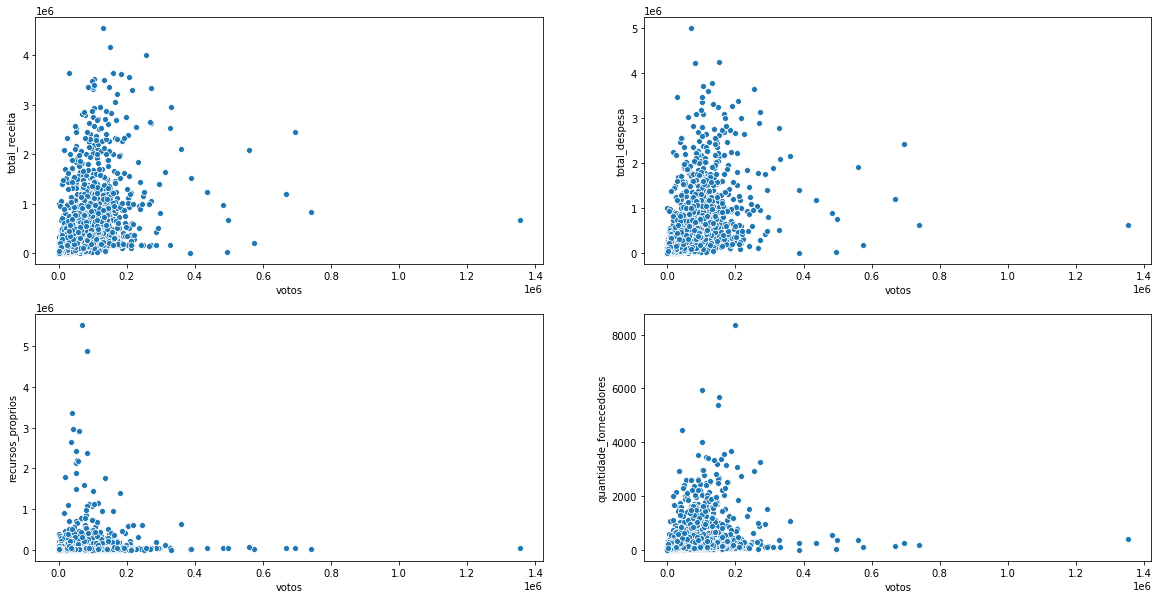

In [6]:
fig,ax = plt.subplots(2,2, figsize=(20,10))
sns.scatterplot(x='votos',y='total_receita',data = df,ax=ax[0][0]);
sns.scatterplot(x='votos',y='total_despesa',data = df,ax=ax[0][1]);
sns.scatterplot(x='votos',y='recursos_proprios',data = df,ax=ax[1][0]);
sns.scatterplot(x='votos',y='quantidade_fornecedores',data = df,ax=ax[1][1]);

é possível observar que os dados não seguem uma distribuição linear e, por esta razão, a correlação de Spearman se comportará melhor para que possamos observar a correlação entre os dados

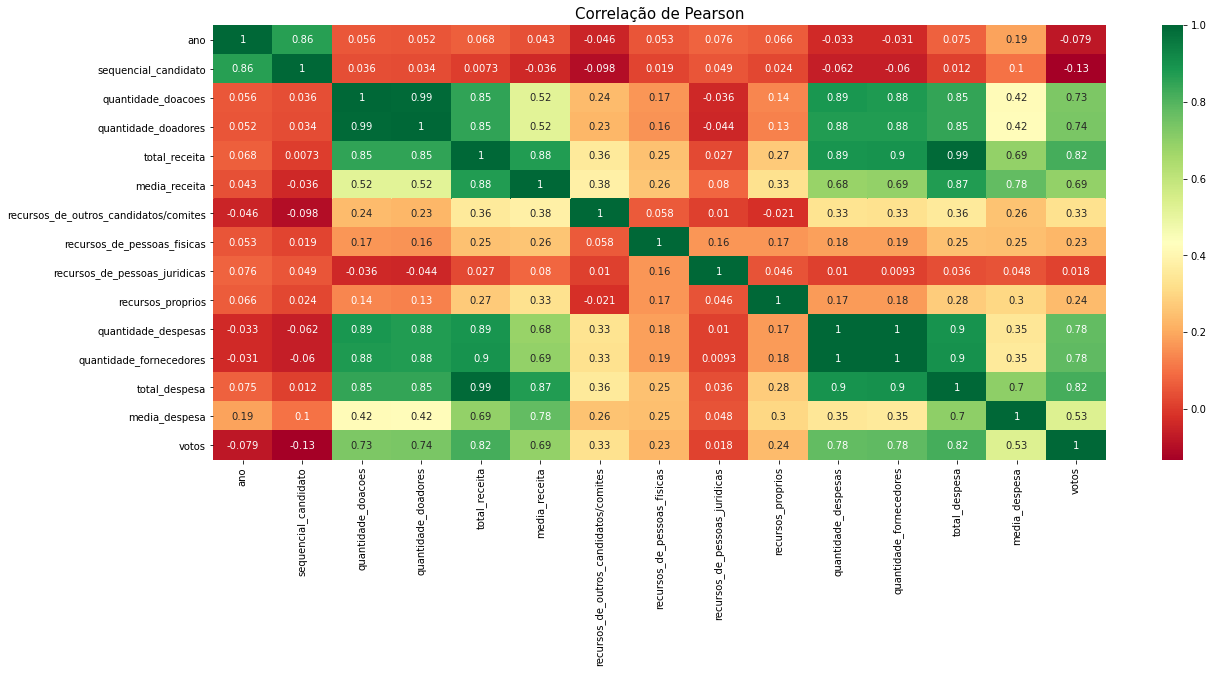

In [7]:
plt.figure(figsize=(20,8))
sns.heatmap(df.corr('spearman'), annot = True, cmap= "RdYlGn");
plt.title('Correlação de Pearson',size=15);

Como os dados não possuem uma clara distribuição linear, vamos colocar os dados em logaritmos para que consigamos ter uma melhor vizualização das correlações

In [8]:
numeric_feats = df.dtypes[df.dtypes != "object"].index

skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats.index

df[skewed_feats] = np.log1p(df[skewed_feats])

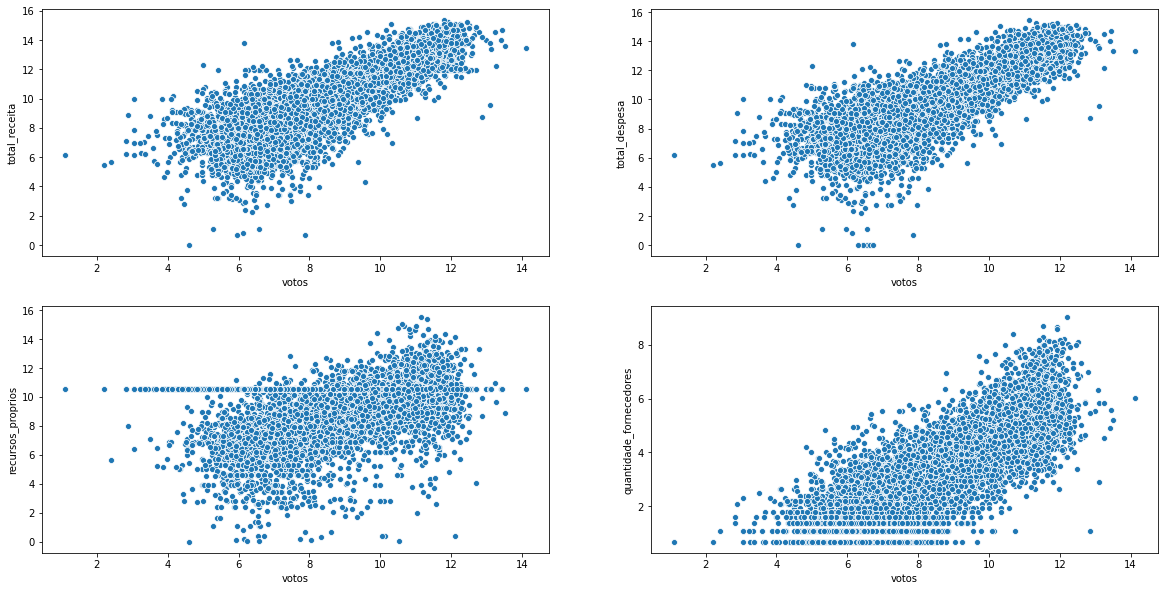

In [9]:
fig,ax = plt.subplots(2,2, figsize=(20,10))
sns.scatterplot(x='votos',y='total_receita',data = df,ax=ax[0][0]);
sns.scatterplot(x='votos',y='total_despesa',data = df,ax=ax[0][1]);
sns.scatterplot(x='votos',y='recursos_proprios',data = df,ax=ax[1][0]);
sns.scatterplot(x='votos',y='quantidade_fornecedores',data = df,ax=ax[1][1]);

In [10]:
#Variáveis independentes
X = df.drop(['ano','sequencial_candidato', 'nome', 'uf', 'partido', 'cargo', 'sexo', 'grau',
       'estado_civil', 'ocupacao', 'votos'],axis=1)
#Variável dependentes
y = df['votos']

In [11]:
modelo = LinearRegression()
modelo.fit(X,y)

LinearRegression()

In [12]:
modelo.score(X,y)

0.7112487473437319

Para os dados de Teste vamos efetuar as mesmas transformações que nos dados de teste

In [13]:
df_teste = pd.read_csv('eleicoes_2014.csv')

df_teste = df_teste.fillna(df_teste.mean())

numeric_feats = df_teste.dtypes[df_teste.dtypes != "object"].index

skewed_feats = df_teste[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats.index

df_teste[skewed_feats] = np.log1p(df_teste[skewed_feats])

df_teste.head()

,ano,sq_candidato,nome_candidato,sigla_uf,sigla_partido,qtd_doacoes,qtd_doadores,total_receita,media_receita,recursos de outros candidatos/comitês,recursos de pessoas físicas,recursos de pessoas jurídicas,recursos próprios,qtd_despesas,qtd_fornecedores,total_despesa,media_despesa,descricao_cargo,sexo,grau_instrucao,estado_civil,descricao_ocupacao,votos
0,7.608374,23.025851,EMERSON DA SILVA SANTOS,AC,PSOL,1.386294,1.386294,7.365813,6.268465,10.419316,7.313887,12.224391,10.681994,1.386294,1.386294,7.365813,6.268465,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,SOLTEIRO(A),"CORRETOR DE IMÓVEIS, SEGUROS, TÍTULOS E VALORES",3.637586
1,7.608374,23.025851,GERALDO SILVA DOS SANTOS,AC,PSOL,1.791759,1.791759,8.064951,6.456770,10.419316,8.039480,12.224391,10.681994,1.945910,1.791759,8.049114,6.440953,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,SOLTEIRO(A),VIGILANTE,5.950643
2,7.608374,23.025851,CARLOS CESAR CORREIA DE MESSIAS,AC,PSB,3.713572,3.663562,12.716781,9.079305,7.562198,11.092869,11.945818,11.652696,4.983607,4.941642,12.697320,7.763268,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL INCOMPLETO,CASADO(A),OUTROS,10.182974
3,7.608374,23.025851,IDESIO LUIS FRANKE,AC,PT,3.401197,3.401197,11.962218,8.595101,10.574474,11.138739,9.741027,8.826758,4.919981,4.804021,12.392623,7.597330,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),AGRÔNOMO,9.199987
4,7.608374,23.025851,LEONARDO CUNHA DE BRITO,AC,PT,5.081404,4.990433,13.474546,8.491143,9.210440,12.757293,12.531776,11.264477,6.251904,5.872118,13.248824,7.380149,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),ADVOGADO,9.946403


In [14]:
X_test = df_teste.drop(['ano','sq_candidato', 'nome_candidato', 'sigla_uf', 'sigla_partido', 'descricao_cargo', 'sexo', 'grau_instrucao',
       'estado_civil', 'descricao_ocupacao', 'votos'],axis=1)
y_test = df_teste['votos']

In [15]:
y_pred = modelo.predict(X_test)
y_pred

array([ 6.71393872,  7.11538966, 10.27923181, ...,  6.58950233,
        6.50200586,  7.89135186])

In [16]:
modelo.coef_

array([-3.34888074e-01,  9.35304817e-01, -1.03813153e-01,  3.78265939e-01,
        4.72376571e-02,  9.82196391e-05, -2.15719297e-02, -2.36441492e-03,
        2.69084699e-01,  1.48975462e+00, -1.24159913e+00,  1.46700362e+00])

In [17]:
print("RMSE: %.2f" % mean_squared_error(y_test,y_pred, squared = False))

RMSE: 1.90


## Ridge

In [18]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha=.1)
reg.fit(X,y)

reg.coef_

array([-3.34262349e-01,  9.35178989e-01, -1.04310185e-01,  3.78816894e-01,
        4.72454298e-02,  1.87334022e-04, -2.15197744e-02, -2.28291716e-03,
        2.69505314e-01,  1.48330126e+00, -1.23607590e+00,  1.46133104e+00])

In [19]:
reg_y_pred = reg.predict(X_test)
reg_y_pred

array([ 6.713919  ,  7.11580789, 10.27918686, ...,  6.58948698,
        6.50151017,  7.89170617])

In [20]:
print("RMSE: %.2f" % mean_squared_error(y_test,reg_y_pred, squared = False))

RMSE: 1.90


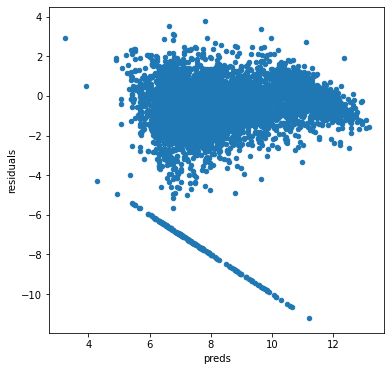

In [21]:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":reg_y_pred, "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

### Ridge with cross validation

In [22]:
from sklearn.linear_model import RidgeCV
alphas = [1e-3, 1e-2, 1e-1, 1]
clf = RidgeCV(alphas=alphas).fit(X, y)
clf.score(X, y)

0.7112486616253798

In [23]:
clf_y_pred = clf.predict(X_test)
clf_y_pred

array([ 6.713919  ,  7.1158079 , 10.27918685, ...,  6.58948699,
        6.50151017,  7.89170617])

In [24]:
print("RMSE: %.2f" % mean_squared_error(y_test,clf_y_pred, squared = False))

RMSE: 1.90


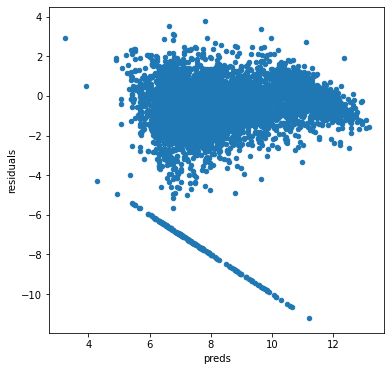

In [25]:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":clf_y_pred, "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

## Lasso

In [26]:
las = linear_model.Lasso(alpha=0.1)
las.fit(X,y)

las_y_pred = las.predict(X_test)
las_y_pred

array([ 6.70687921,  7.20481803, 10.27167954, ...,  6.57817466,
        6.33812083,  8.02948401])

In [27]:
print("RMSE: %.2f" % mean_squared_error(y_test,las_y_pred, squared = False, multioutput='raw_values'))

RMSE: 1.92


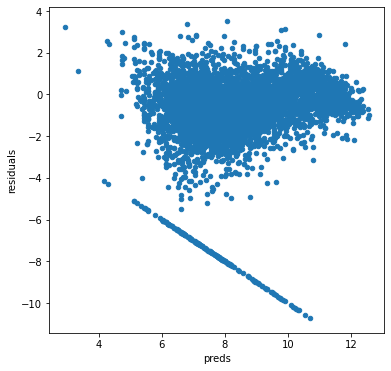

In [28]:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":las_y_pred, "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

### Lasso with cross validation

In [29]:
from sklearn.linear_model import LassoCV
clf_las = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X, y)
clf_las.score(X, y)

clf_las_y_pred = clf_las.predict(X_test)
clf_las_y_pred

array([ 6.7127178 ,  7.14092101, 10.27532832, ...,  6.58839763,
        6.4758928 ,  7.90968471])

In [30]:
print("RMSE: %.2f" % mean_squared_error(y_test,clf_las_y_pred, squared = False))

RMSE: 1.90


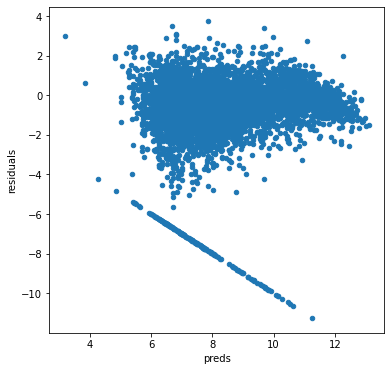

In [31]:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":clf_las_y_pred, "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

## KNN Model

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

knn_model = KNeighborsRegressor(n_neighbors=3)

knn_model.fit(X, y)


KNeighborsRegressor(n_neighbors=3)

In [33]:
train_preds = knn_model.predict(X)
mse = mean_squared_error(y, train_preds)
rmse = sqrt(mse)
print("RMSE: %.2f" % rmse)

RMSE: 0.79


In [34]:
test_preds = knn_model.predict(X_test)
mse = mean_squared_error(y_test, test_preds)
rmse = sqrt(mse)
print("RMSE: %.2f" % rmse)


RMSE: 1.97


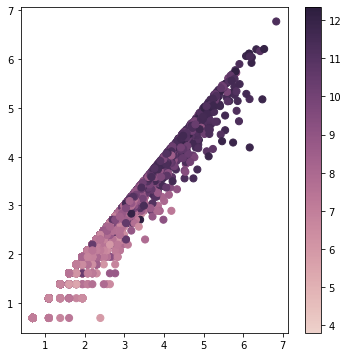

In [35]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(
    X_test.iloc[:, 0], X_test.iloc[:, 1], c=test_preds, s=50, cmap=cmap
)
f.colorbar(points)
plt.show()

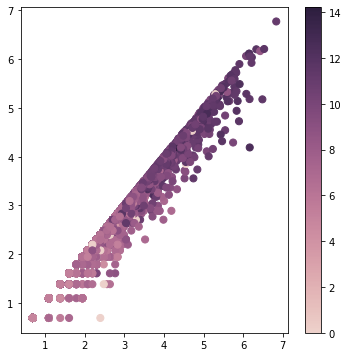

In [36]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(
    X_test.iloc[:, 0], X_test.iloc[:, 1], c=y_test, s=50, cmap=cmap
)
f.colorbar(points)
plt.show()

## Resultados

A regressão linear multivariada (RLM) com e sem validação cruzada (CV) gerou um um RMSE praticamente iguais para o Ridge e Lasso (também com e sem CV) com a diferença que a regularização Lasso sem CV teve uma piora de 0.2 o que é desprezivel, mas, não deixando de ser pior que os outros.

Em comparação com o KNN, este demonstrou ser ainda pior que os anteriores com a diferença de 0.7 em relação aos demais.

Dessa forma, o modelo que mais se adequou aos dados foram: RLM sem regularização, com Ridge (com ou sem CV) e Lasso (com CV).